[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ArtIC-TITECH/b3-proj-2023/blob/main/docs/class_01.ipynb)

# ニューラルネットワークを用いたMNISTデータセットの学習

## 目次

1. ニューラルネットワークを用いた線形関数の近似
2. ニューラルネットワークを用いた手書き文字認識

## 1. ニューラルネットワークを用いた線形関数の近似

ニューラルネットワークは、ChatGPTや画像生成AIなどの基盤となる技術です。  
その基本原理は、関数近似に基づいており、複雑な関数を近似できるのが特徴です。  
この章では、ニューラルネットワークで関数近似を行う簡単な例を紹介します。

ニューラルネットワークの学習は以下の流れで行います。
1. データセットの作成
1. モデルの作成
1. 損失関数、最適化関数の定義
1. モデルの学習
1. モデルの評価

今回の例ではニューラルネットワークのモデルとしてy=wx+bを用意して、そのモデルにy=2x+1を学習させます。  具体的には以下のような流れです。
1. y=2x+1のデータを作成
1. 初期値をw=0, b=0としてモデルy=wx+bを作成
1. 最小化するべき関数とw, bの更新式を定義
1. wとbを更新
1. 得られたw, bを確認

本題に入る前に本日使用するライブラリをimportします。

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

### 1-1.データセットの作成

ニューラルネットワークの学習に用いるデータセットを作成します。今回の例ではy=2x+1の関数近似をします。

In [2]:
w = 2  # 傾き
b = 1  # 切片
x_train = np.linspace(0, 9, 10)  # 0から9までの10個のデータ点を生成
y_train = w * x_train + b  # 真の線形関数

In [3]:
x_train

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [4]:
y_train

array([ 1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19.])

データ型をNumpyのarrayからPyTorchのtensorに変換します。PyTorchの処理の都合上、view(-1, 1)を使って形状を(10, 1)にします。

In [5]:
# Tensorに変換
x_train = torch.tensor(x_train, dtype=torch.float32).view(-1, 1)  # (10, 1) の形に
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # (10, 1) の形に

In [6]:
x_train

tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.],
        [9.]])

In [7]:
y_train

tensor([[ 1.],
        [ 3.],
        [ 5.],
        [ 7.],
        [ 9.],
        [11.],
        [13.],
        [15.],
        [17.],
        [19.]])

### 1-2.モデルの作成

ニューラルネットワークを作成します。  
self.linear=nn.Linear(入力サイズ, 出力サイズ)  
は(出力サイズ$\times$入力サイズ)の重み行列$\mathbf{W}$と(出力サイズ)のバイアスベクトル$b$を生成します。  
そして(入力サイズ)のベクトルxを入力した際、self.linear(x)は$\mathbf{W}x+b$を返します。  
今回は入力サイズも出力サイズも1なので$y=wx+b$とかけます。

In [8]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(1, 1)  # 入力1、出力1の線形層
        init.constant_(self.linear.weight, 0)  # 重みwをすべて0に初期化
        init.constant_(self.linear.bias, 0)    # バイアスbをすべて0に初期化

    def forward(self, x):
        return self.linear(x)

# モデルのインスタンスを作成
model = LinearRegressionModel()

重みwとバイアスbをどちらも0にしたのでモデルはy=0x+0=0となり、入力に関わらず出力は0になります。

In [9]:
model(torch.Tensor([1])) # モデルにx=1を入れた際の結果

tensor([0.], grad_fn=<ViewBackward0>)

In [10]:
model(torch.Tensor([[0], [1], [2], [3]])) # x=0からx=3までを入力した結果をまとめて確認することもできます

tensor([[0.],
        [0.],
        [0.],
        [0.]], grad_fn=<AddmmBackward0>)

モデルが現在y=0x+0であることは以下のプロットで確認できます。

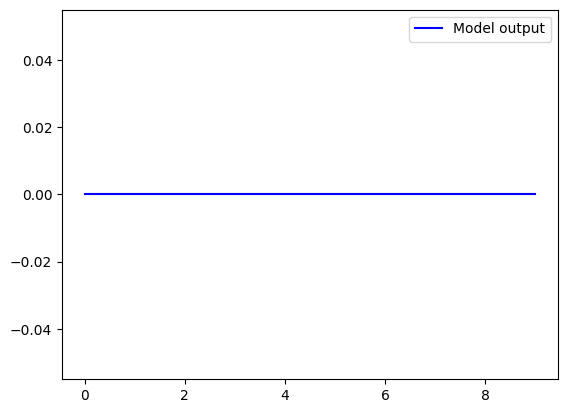

In [11]:
with torch.no_grad():
    predicted = model(x_train).detach().numpy()

plt.plot(x_train.numpy(), predicted, label='Model output', color='blue')
plt.legend()
plt.show()

###1-3. 損失関数, 最適化関数の定義

詳細は後述しますが  
損失関数としてMSELoss (Mean squared error, 平均二乗誤差)を使用します。  
また最適化関数としてSGD (Stochastic gradient descent, 確率的勾配降下法)を使用します。

In [12]:
criterion = nn.MSELoss()  # 平均二乗誤差を損失関数として使用
optimizer = optim.SGD(model.parameters(), lr=0.01) # 確率的勾配降下法を最適化関数として使用

### 1-4. モデルの学習


モデルの学習で重要なのが損失関数と最適化関数です。

#### 損失関数について
平均二乗誤差を使ったlossはニューラルネットワークの出力y_pred=wx+bと正解データy_trainを用いて  
$\text{loss}=(\text{y_pred}-\text{y_train})^2=(wx+b-\text{y_train})^2$  
で計算されます。  
例としてx=1のときy=2x+1の正解データはy_train=3です。しかしモデルの出力はy_pred=0だったとします。このときlossは$\text{loss}=(0-3)^2=9$となります。モデルはlossができるだけ小さくなるように学習を行います。

#### 最適化関数について
lossを小さくするために、モデルは$y=wx+b$の$w$と$b$をそれぞれ大きくするべきか、小さくするべきか知りたいです。これを知るためにlossをwやbで微分した結果が役立ちます。  
$$
\frac{\partial\text{loss}}{\partial{w}}=2(wx+b-\text{y_train})x
$$
が0より大きい場合、wを増やすとlossも大きくなります。反対に0より小さい場合、wを減らすとlossが大きくなります。  
したがって$\lambda(>0)$を微小量として以下のようにwを更新します。
$$
w = w-\lambda\frac{\partial\text{loss}}{\partial{w}}
$$
$\lambda$は最適化関数を定義する際にlrで指定します。  
optimizer = optim.SGD(model.parameters(), lr=0.01)

<img src="https://raw.githubusercontent.com/ArtIC-TITECH/b3-proj-2024/refs/heads/main/resources/class_01/58921711597.png" width="70%">



#### 損失と勾配の確認

実際にy=0x+0にx=1を入れた際の損失と勾配を確認します。
近似したい関数はy=2x+1だとします。

In [13]:
# x=1とします
x = torch.Tensor([1])

# モデルの予測
y = model(x)
y

tensor([0.], grad_fn=<ViewBackward0>)

損失関数  
$\text{loss}=(\text{y_pred}-\text{y_train})^2=(wx+b-\text{y_train})^2$  
は以下のコードで計算できます。

In [14]:
# lossの表示
loss = criterion(y, 2*x+1)
loss

tensor(9., grad_fn=<MseLossBackward0>)

lossに対するwの勾配
$$
\frac{\partial\text{loss}}{\partial{w}}
$$
は以下のコードで計算できます。

In [15]:
# 勾配の計算
loss.backward()

# aの勾配の表示
print(model.linear.weight.grad)

tensor([[-6.]])


#### 学習の実行

上記の損失関数と最適化関数でwとbの更新を5回行います。

In [16]:
epochs = 5
for epoch in range(epochs):
    # モデルの予測
    y_pred = model(x_train)

    # 損失の計算
    loss = criterion(y_pred, y_train)

    # 勾配の初期化
    optimizer.zero_grad()

    # バックプロパゲーション
    loss.backward()

    # 重みの更新
    optimizer.step()

    # 損失を表示
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/5], Loss: 133.0000
Epoch [2/5], Loss: 23.0816
Epoch [3/5], Loss: 4.0907
Epoch [4/5], Loss: 0.8086
Epoch [5/5], Loss: 0.2404


### 1-5. モデルの評価

y=2x+1に近いモデルが得られました。

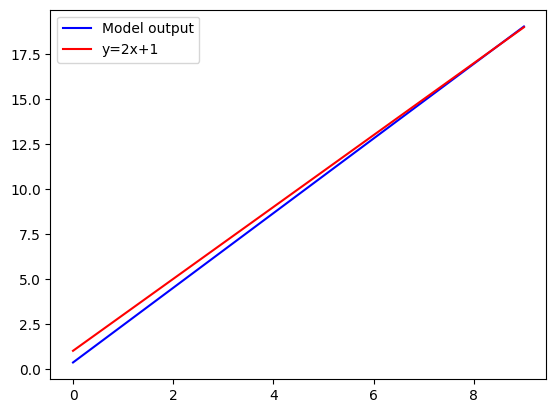

In [17]:
with torch.no_grad():
    predicted = model(x_train).detach().numpy()

plt.plot(x_train.numpy(), predicted, label='Model output', color='blue')
plt.plot(x_train.numpy(), y_train.numpy(), label='y=2x+1', color='red')
plt.legend()
plt.show()

## 2. ニューラルネットワークを用いた手書き文字認識

### MNISTデータセットについて

MNISTデータセットは0から9までの手書き数字の画像を集めたデータセットです。  
各画像は28x28ピクセルのグレースケール画像です。  
今回は手書き数字の画像を入力した際、その数字を当てるようにニューラルネットワークのモデルの学習を行います。  
手順は線形近似と同様で以下の通りです。

1. データセットの作成
1. モデルの作成
1. 損失関数、最適化関数の定義
1. モデルの学習
1. モデルの評価

### 2-1 データセットの作成

データセットを読み込む前にデータセットに対して行う処理を決めます。


In [18]:
# 普通のtransform
transform_normal = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# テストデータには普通のtransformを使ってください
transform_for_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# ランダム回転を加えたtransform
transform_rotation = transforms.Compose([
    transforms.RandomRotation(60),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# ランダム水平反転を加えたtransform
transform_flip = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

データセットの一部を表示する関数です。

In [19]:
# 画像表示用の関数（3つの画像を横に並べる）
def imshow(img):
    img = img / 2 + 0.5  # Normalizeされた画像の逆変換
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

# サンプル画像を取得して表示（3つの画像を並べる）
def show_samples(dataset, title):
    loader = torch.utils.data.DataLoader(dataset, batch_size=3, shuffle=False)  # 3つ取得
    data_iter = iter(loader)
    images, labels = next(data_iter)  # 3つの画像を取得

    print(f"Samples from {title}:")
    imshow(torchvision.utils.make_grid(images, nrow=3))  # 3つ横に並べて表示
    print(labels)

普通のtransformの結果です。(もともとのデータが表示されます。)

Samples from train dataset:


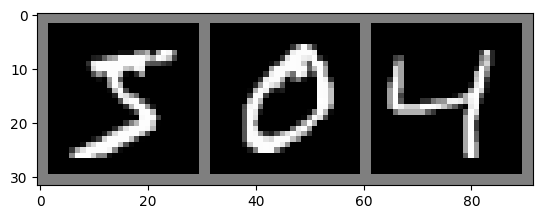

tensor([5, 0, 4])


In [20]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_normal)
show_samples(train_dataset, "train dataset")

ランダム回転を加えたtransformの結果です。

Samples from train dataset:


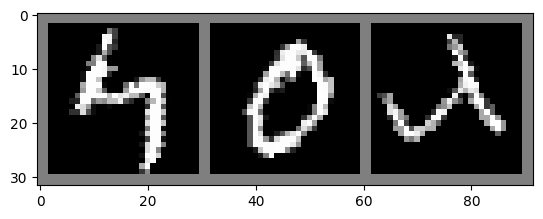

tensor([5, 0, 4])


In [21]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_rotation)
show_samples(train_dataset, "train dataset")

ランダム水平反転を加えたtransformの結果です。

Samples from train dataset:


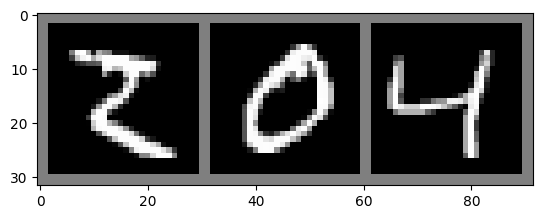

tensor([5, 0, 4])


In [22]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_flip)
show_samples(train_dataset, "train dataset")

データ変換は複数同時に適用することがほとんどで、そのような場合は`transforms.Compose`を使用して複数のデータ変換を一連の処理として指定します。
```python
transform = transforms.Compose(
    [transforms.ToTensor(),
    ...
     ])
```
のようにpythonのリストで指定し、データを読み込む際に上から順番に実行されます。
適用可能な関数の一覧は[こちら](https://pytorch.org/vision/main/transforms.html)を参照してください。

transformを使うことで、モデルの学習に使うデータの水増しができます。  
今回は普通のtransformを使います。

In [23]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_normal) # モデルの学習に使うデータセット
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_normal) # モデルの評価に使うデータセット

In [24]:
len(train_dataset) # モデルの学習に使うデータセットのサイズ確認

60000

In [25]:
len(test_dataset) # モデルの評価に使うデータセットのサイズ確認

10000

データセットに含まれるデータ数は非常に大きく、一度にメモリに読み込むことは難しい場合が多いです。  
そのため、そこで一度に読み出すデータの数を減らすことで計算負荷を減らしています。  
これをミニバッチと呼び、ロードするデータ数をバッチサイズと呼びます。

一度にすべてのデータを入力するバッチ処理  
<img src="https://raw.githubusercontent.com/ArtIC-TITECH/b3-proj-2024/refs/heads/main/resources/class_01/batch_gd.png" width="60%">

データを分割して入力するミニバッチ処理  
<img src="https://raw.githubusercontent.com/ArtIC-TITECH/b3-proj-2024/refs/heads/main/resources/class_01/minibatch_gd.webp" width="60%">

pytorchでは、こうしたミニバッチ処理を`DataLoader`というクラスを用いて行います。\
`DataLoader`は`batch_size`という引数で一度に読み出すデータの数を指定することができます。

In [26]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

これによってtrain_loaderからデータを1回取り出すごとに64個ずつ、画像とそれに対応するラベルを読み出すことができます。

In [27]:
for images, labels in train_loader:
    print("Images shape:", images.shape)  # 形状の表示
    print("Labels shape:", labels.shape)  # 形状の表示
    break # 一回目のループで終了

Images shape: torch.Size([64, 1, 28, 28])
Labels shape: torch.Size([64])


### 2-2.モデルの作成

今回は28$\times$28の手書き数字画像を784(=28$\times$28)個の要素を持つベクトルとして扱います。  
画像は0から9の数字のいずれかなのでモデルは10個の要素を持つベクトルを出力します。ベクトルのそれぞれの要素は0から9の各数字に対応しており、入力された画像に対応するベクトル要素が大きくなりそれ以外の要素が小さくなるように学習を行います。

In [28]:
## Please update the path to your own directory.
# path=/path/to/your_own  # Uncomment this line
path = '../../work/data/cifar10'

## Define Augmentation
transform = transforms.Compose(
    [transforms.ToTensor(),
     ])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root=path, train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=path, train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### データセット・データローダーの確認

先ほどのデータセットにどのようなデータが保存されているのか確認します。

`images`は$[B\times 3\times 32\times 32]$のテンソルでモデルの入力に使用します。\
また、`labels`は$[B]$のテンソルで学習のラベルとして使われます。ここで、$B$はバッチサイズを表します。

下のセルを実行すると変数`batch_size`で指定した数と同じ枚数の画像が出力されるのがわかるかと思います。

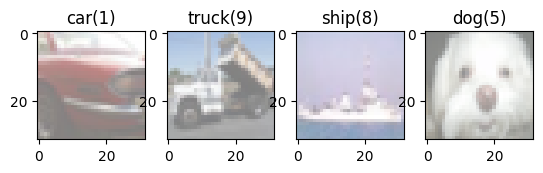

car   truck ship  dog  


In [29]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
torch.manual_seed(15)

def imshow(imgs, labels):
    imgs = imgs / 2 + 0.5     # unnormalize
    npimg = imgs.numpy()
    for i, (img, label) in enumerate(zip(npimg, labels)):
        plt.subplot(1, batch_size, i+1)
        plt.grid(False)
        plt.imshow(np.transpose(img, (1, 2, 0)))
        label = label.item()
        plt.title(f"{classes[label]}({label})")

    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(images, labels)
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 演習

- データ変換に正規化を追加してください。
- バッチサイズを4に変更した場合に出力がどう変化するか確認してください。
- ランダムに上下を反転させるデータ変換を追加してください。(任意)

## モデルの作成
ここでは、推論に使用するモデルの作成を行います。

モデルを作成する前にニューラルネットワークで広く用いられるモデルの構成要素について簡単に説明します。

### 全結合層
<img src="https://github.com/ArtIC-TITECH/b3-proj-2023/blob/main/resources/class_01/fully_connected.png?raw=1" width="10%">

全結合層とは、入力と出力が全て重みによって結合されている層を指します。\
図では、一次元で表していますが、`pytorch`ではバッチ処理が行われるため実際は2次元の入力に対して処理が行われます。\
そのため、入力$\mathbf{x} \in \mathbb{R}^{B\times C_{\rm in}}$に対して、重み$W\in\mathbb{R}^{C_{\rm in}\times C_{\rm out}}$とバイアス$\mathbf{B} \in \mathbb{R}^{B\times C_{\rm out}}$を用いて出力$y\in\mathbb{R}^{B\times C_{\rm out}}$は次のように計算されます。
$$\mathbf{y} = \mathbf{x}\mathbf{W} + \mathbf{B}$$
ここで、$B$はバッチサイズ、$C_{\rm in}$、$C_{\rm out}$は入力チャネル、出力チャネル数を表しています。

`pytorch`では`nn.Linear`というクラスで実装されています。\
`in_features`で入力のチャネル数、`out_features`で出力のチャネル数を指定します。

例えば、入力チャネルが$4$、出力チャネルが$10$の全結合層は次のように実装します。

In [30]:
import torch.nn as nn
input = torch.rand((4, 3))
print(f'Input Shape is {input.shape}')
linear = nn.Linear(in_features=3, out_features=10)
output = linear(input)
print(f'Output Shape is {output.shape}')

Input Shape is torch.Size([4, 3])
Output Shape is torch.Size([4, 10])


演習
上のセルを修正して入力チャネルが5、出力チャネルが15の線形層を`nn.Linear`を用いて実装してください。\
このとき、入力のバッチサイズを4とし、線形層の入力チャネルと入力データのチャネル数を揃える必要があることに注意してください。


### 畳み込み層
<img src="https://github.com/ArtIC-TITECH/b3-proj-2023/blob/main/resources/class_01/conv1d.png?raw=1" width="30%">

全結合層では全ての入力チャネルと出力チャネルが重みで結合されていたのに対し、畳み込み層では入力に対してカーネルをストライドさせることで出力を計算します。\
そのため、出力のサイズは、カーネルサイズ、ストライド、パディングによって決定されます。\
画像では1次元のデータに対する1次元の畳み込みを例にしていますが、画像のデータセットでは4次元の入力に対し2次元の畳み込みを行うことが一般的です。\
この場合カーネルは$[C_{\rm out}, C_{\rm in}, k_{\rm h}, k_{\rm w}]$の4次元のテンソルで定義され、このカーネルを画像の縦横方向にストライドさせることで計算を行います。

例えば、入力サイズが$[4, 3, 10, 10]$のデータに対して、出力チャネル6、カーネルサイズ3、パディングおよびストライドが1の畳み込みは次のように実装されます。

In [31]:
import torch.nn as nn
input = torch.rand((4, 3, 10, 10))
print(f'Input Shape is {input.shape}')
conv2d = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, padding=1, stride=1)
output = conv2d(input)
print(f'Output Shape is {output.shape}')

Input Shape is torch.Size([4, 3, 10, 10])
Output Shape is torch.Size([4, 6, 10, 10])


演習
上のセルを修正して入力チャネルが5、出力チャネルが10のカーネルサイズが5、パディングが0、ストライドが1のConvを実装してください。\
このとき、入力のバッチサイズを4とし、入力チャネルと入力データのチャネル数を揃える必要があることに注意してください。\
出力のサイズが変化していることを確認してください。

### プーリング層

プーリング層は畳み込み層と同様にカーネルを画像の$H$、$W$方向に動かしながら処理を行いますが、次の2点で畳み込み層と異なります。
- チャネル間の情報を集約しない
- カーネルは重みではなく決まった処理が行われる
    - MaxPool2dでは、カーネル内の最大値が出力される
    - AvgPool2dでは、カーネル内の平均値が出力される

例えば、カーネルサイズ$2$、ストライド$2$のMaxPool2dは次のように使用します。\
入出力を比較すると$2\times2$のカーネルの中から最大値が選ばれていることがわかります。

In [32]:
import torch.nn as nn
input = torch.rand((4, 3, 8, 8))
print(input[0][0])
pool = nn.MaxPool2d(kernel_size=2, stride=2)
output = pool(input)

print(output[0][0])

tensor([[0.8463, 0.5517, 0.0251, 0.6050, 0.9254, 0.4521, 0.1311, 0.9100],
        [0.3055, 0.6125, 0.6766, 0.4657, 0.2367, 0.5747, 0.1556, 0.9475],
        [0.2736, 0.2088, 0.8203, 0.1927, 0.3703, 0.7752, 0.6978, 0.5954],
        [0.8937, 0.3659, 0.6417, 0.8603, 0.9464, 0.8841, 0.8414, 0.6137],
        [0.1033, 0.3468, 0.8249, 0.5278, 0.3253, 0.7776, 0.8857, 0.0934],
        [0.6885, 0.3277, 0.7715, 0.2622, 0.6311, 0.5499, 0.5862, 0.3351],
        [0.7002, 0.7683, 0.7008, 0.3214, 0.0863, 0.0671, 0.4806, 0.4913],
        [0.7177, 0.8152, 0.6141, 0.7273, 0.4063, 0.8808, 0.0174, 0.5061]])
tensor([[0.8463, 0.6766, 0.9254, 0.9475],
        [0.8937, 0.8603, 0.9464, 0.8414],
        [0.6885, 0.8249, 0.7776, 0.8857],
        [0.8152, 0.7273, 0.8808, 0.5061]])


### 活性化関数
活性化関数とは、入力に対して非線形処理を適用しニューラルネットワークの表現力を向上させるために使用する関数です。

活性化関数には様々な種類がありますが、今回の演習では`ReLU`関数を非線形関数として用います。\
次のコードは入力に対して`ReLU`を適用したもので、$0$以下の入力が全て$0$となることがわかります。

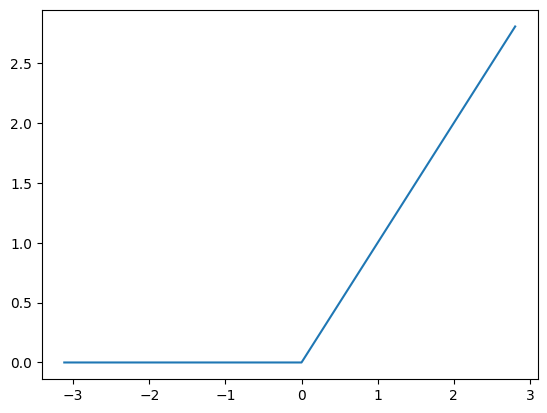

In [33]:
import matplotlib.pyplot as plt
import torch.nn as nn

input = torch.randn(100,)
act = nn.ReLU()
output = act(input)
plt.plot(input.sort().values, output.sort().values)

ここまでで説明した4つの構成要素を用いてニューラルネットワークは次のように実装されます。\
ここでは、畳み込み1層、プーリング層1層、全結合層1層のニューラルネットワークを実装しています。

In [34]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.act = nn.ReLU()
        self.fc1 = nn.Linear(in_features=6*14*14, out_features=10)

    def forward(self, x):
        x = self.pool(self.act(self.conv1(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

### 実際にモデルを動かしてみよう

ここでは乱数を入力としてモデルを動かしてみます。
ニューラルネットワークは、入力サイズ$(B, C, H, W)$のテンソルを入力として、$(B, \rm{Cls})$を出力とします。\
ここで$B$はバッチサイズ、$C$は入力チャネル数(RGB画像の場合は3チャネル)、$H$, $W$は画像の幅と高さになります。CIFAR-10データセットの場合は、$H=W=32$です。\
$\rm{Cls}$は出力のクラス数を表し、CIFAR-10は10クラスを出力します。\
ここでは、$(B, C, H, W) = (1, 3, 32, 32)$の乱数を入力としてモデルの推論を行います。\
実際にコードを実行すると(1, 10)の出力が得られると思います。出力の各要素がそれぞれのクラスの予測値となります。

In [35]:
torch.manual_seed(100)

input = torch.rand((1, 3, 32, 32))
net = Net()
output = net(input)

print(output)

tensor([[-0.2280,  0.2704,  0.0418, -0.3525, -0.0435, -0.0122, -0.0838,  0.0160,
         -0.3922,  0.1603]], grad_fn=<AddmmBackward0>)


演習\
`Net`クラスを修正して以下で定義されるモデルを実装してください。\
Conv2dは全て`padding=0`、`stride=1`で、MaxPool2dは`stride=2`で実装してください。\
それぞれの層のカーネルサイズは、テーブルの`Kernel Shape`を元に決定してください。\
それぞれの層のチャネル数は、入力チャネル、出力チャネルを参考に実装してください。\
最終層以外のConv, Linear層の後には

```
===================================================================================================================
Layer (type:depth-idx)                   Input Shape               Output Shape              Kernel Shape
===================================================================================================================
Net                                      [4, 3, 32, 32]            [4, 10]                   --
├─Conv2d: 1-1                            [4, 3, 32, 32]            [4, 6, 28, 28]            [5, 5]
│    └─weight                                                                                [3, 6, 5, 5]
│    └─bias                                                                                  [6]
|-ReLU                                   [4, 6, 28, 28]            [4, 6, 28, 28]
├─MaxPool2d: 1-2                         [4, 6, 28, 28]            [4, 6, 14, 14]            2
├─Conv2d: 1-3                            [4, 6, 14, 14]            [4, 16, 10, 10]           [5, 5]
│    └─weight                                                                                [6, 16, 5, 5]
│    └─bias                                                                                  [16]
|-ReLU                                   [4, 16, 10, 10]           [4, 16, 10, 10]
├─MaxPool2d: 1-4                         [4, 16, 10, 10]           [4, 16, 5, 5]             2
├─Linear: 1-5                            [4, 400]                  [4, 120]                  --
│    └─weight                                                                                [400, 120]
│    └─bias                                                                                  [120]
|-ReLU                                   [4, 120]                  [4, 120]
├─Linear: 1-6                            [4, 120]                  [4, 84]                   --
│    └─weight                                                                                [120, 84]
│    └─bias                                                                                  [84]
|-ReLU                                   [4, 84]                   [4, 84]
├─Linear: 1-7                            [4, 84]                   [4, 10]                   --
│    └─weight                                                                                [84, 10]
│    └─bias                                                                                  [10]
===================================================================================================================
```



## 損失関数とオプティマイザの定義

損失関数$L$とはモデルの予測値と正解ラベルの誤差を計算するための関数です。\
損失関数は`CrossEntropyLoss`というラベルデータの確率分布と出力の確率分布の誤差を計算する関数が主に使用されます。\
また、オプティマイザーとはパラメータを更新するための関数で、画像認識では`SGD`や`Adam`などが広く使用されています。

今回の演習では、`SGD`をオプティマイザとして使用します。
`SGD`の第一引数は更新するパラメータを指定しています。\
第二引数は学習率と呼ばれ、一度に更新するパラメータの大きさを調整しています。\
`momentum`や、今回は使われていませんが`weight_decay`といった引数はニューラルネットワークの学習を安定させたり過学習を抑制するために使用します。

In [36]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### ニューラルネットワークの学習

では、先ほど定義した損失関数とoptimizerを使用して実際にニューラルネットワークの学習を行いましょう。\
最初に説明した通り、ニューラルネットワークの学習はミニバッチ学習と呼ばれるデータセットの一部のデータを使用してパラメータを更新する作業を繰り返し行います。\
データセット内の全てのデータが学習に使用されるイテレーションの数を1エポックと呼び、複数エポック学習することでパラメータの最適化を行います。\

各イテレーションでは、次の4つの処理を主に行います。
- モデルの推論(順伝播)
    - ミニバッチ入力に対してモデルが予測値を出力します。
- 損失の計算
    - モデルの予測値と正解ラベルの誤差を計算します。
- 勾配のリセット
    - 前のイテレーションでパラメータの更新に使用した勾配のリセット。
- 勾配の計算(逆伝播)
    - 損失を元に各パラメータの勾配計算を行います。
- パラメータの更新

In [37]:
for epoch in range(2):
    running_loss = 0.
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        # 1. forward
        outputs = net(inputs)
        # 2. compute loss
        loss = criterion(outputs, labels)

        # 3. reset parameter gradient
        optimizer.zero_grad()

        # 4. backward
        loss.backward()

        # 5. update parameters
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.016
[1,  4000] loss: 1.780
[1,  6000] loss: 1.745
[1,  8000] loss: 1.679
[1, 10000] loss: 1.668
[1, 12000] loss: 1.628
[2,  2000] loss: 1.602
[2,  4000] loss: 1.611
[2,  6000] loss: 1.582
[2,  8000] loss: 1.584
[2, 10000] loss: 1.544
[2, 12000] loss: 1.534
Finished Training


### テストデータを使用した検証
では、先ほど学習したモデルを使用して新しい検証用データに対する精度を測ってみましょう。

まずは、評価に使うデータをテストデータセットからロードします。

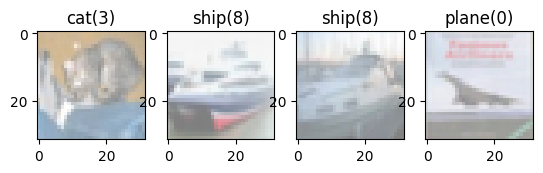

GroundTruth:  cat   ship  ship  plane


In [38]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(images, labels)
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

先ほどロードしたデータを用いて推論を行います。

In [39]:
with torch.no_grad(): # Gradient計算を無効にします
    outputs = net(images)

予測結果を出力してみましょう。

In [40]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  dog   car   ship  ship 


結果はどうでしたか。
次は、テストデータセットを全て用いて精度を確認しましょう。

In [41]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 46 %


クラスごとの精度も確認してみましょう。
どのクラスの精度が一番高かったですか。

In [42]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 62.1 %
Accuracy for class: car   is 75.8 %
Accuracy for class: bird  is 18.9 %
Accuracy for class: cat   is 24.9 %
Accuracy for class: deer  is 22.4 %
Accuracy for class: dog   is 50.4 %
Accuracy for class: frog  is 51.6 %
Accuracy for class: horse is 60.1 %
Accuracy for class: ship  is 61.9 %
Accuracy for class: truck is 33.6 %


学習したモデルは、次のように保存することができます。

In [43]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

保存したモデルは次のようにすることで、保存したパラメータを使用することができます。

In [44]:
net = Net()
net.load_state_dict(torch.load(PATH))

<ipython-input-44-8b61435874a9>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(PATH))


<All keys matched successfully>

最後に学習をGPUを用いて行うように変更します。\
GPUを使用して学習するためには、モデルとデータをGPUに送る必要があります。

まずは、GPUが使用可能か確認します。
次のコードで`False`という結果が出たらGoogle Colaboratoryのランタイムを`GPU`に変更してみてください。

In [45]:
print(torch.cuda.is_available())

False


GPUが使用可能であることがわかったら、モデルとデータをGPUで利用できるようにします。
まず、deviceという変数を一番初めのpythonセルに追加してください。

```python
## Pytorch関連ライブラリ
import torch
import torchvision
import torchvision.transforms as transforms

device = 'cuda:0' # 0番目のGPUをdeviceとして指定
```

モデルの定義部分と、入力及びラベルデータを次のように変更してください。

```python
net = Net()
net = net.to(device)
```

```python
# inputs, labels = data
inputs, labels = data[0].to(device), data[1].to(device)
```

## 宿題
**課題1**: VGG11を実装して評価してください。\
(**課題2**): データ拡張、モデルなどを変更してCIFAR-10の精度を向上させてください。